# AutoUSD, sUSDe, Aave USDC and BIL (1-3 month T-Bill ETF) Comparison

Task:


> 
> Metrics:
> APY  
> Yield Volatility (annualized)  
> Excess vs 3M T-Bill  
> Information Ratio  
> For products:  
> USD: autoUSD, Ethena sUSDe, Aave USDC lending, US Gov short term treasuries  
> ETH: autoETH, Lido staking (stETH), Aave ETH lending  
> Time periods: 30 day, 1 year, since inception  
> *no 1 year on autoUSD since <1 year old  
> Definitions:  
> Yield Volatility: stdev of monthly net returns × √12  
> Excess vs Benchmark: difference between average net APY and the benchmark (3M T-bill for USD; Lido staking rate for ETH).  
> Information Ratio: average monthly excess return ÷ stdev of monthly excess returns, annualized  


# Methods


## Data sources:

Onchain calls on mainnet at the last block of each day

- autoUSD.converToAssets(1e18) / 1e6 -> USDC value of one autoUSD share
- sUSDe -> chainlink sUSDE -> USD oracle, safe USD value of sUSDe over time.
- Aave USDC lending, stataAaveUSDC.convertToAssets(1e6) / 1e6, growth of a share of the aave USDC vault

BIL `SPDR Bloomberg 1-3 Month T-Bill ETF`

https://www.ssga.com/us/en/intermediary/etfs/spdr-bloomberg-1-3-month-t-bill-etf-bil 

> The SPDR® Bloomberg  1-3 Month T-Bill ETF seeks to provide investment results that, before fees and expenses, correspond generally to the price and yield performance of the Bloomberg  1-3 Month U.S. Treasury Bill Index (the "Index")  
> Seeks to provide exposure to publicly issued U.S. Treasury Bills that have a remaining maturities between 1 and 3 months  
> Short duration fixed income is less exposed to fluctuations in interest rates than longer duration securities  
> Rebalanced on the last business day of the month  


As of Oct 26, 2025 BIL has ~42.5B AUM

```
!pip install yfinance
import yfinance as yf
tickers = ['BIL']
data = yf.download(tickers, start="2024-10-26", end="2025-10-26", actions=True)
data.to_csv('data.csv')

```
## Some Other Notes

- Using linear interpolation between for BIL Closing prices because we don't have prices on the weekends and holidays. 
- BIL Closing price is adjusted for dividends


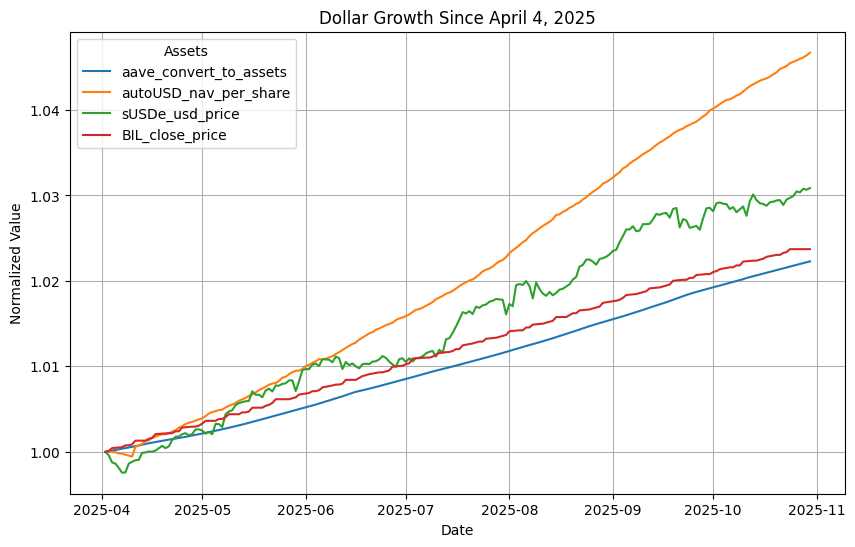

In [ ]:
from multicall import Call

import plotly.express as px
import pandas as pd
import numpy as np

from mainnet_launch.data_fetching.get_state_by_block import (
    get_state_by_one_block,
    build_blocks_to_use,
    get_raw_state_by_blocks,
    safe_normalize_6_with_bool_success,
    safe_normalize_with_bool_success,
)
from mainnet_launch.constants import ETH_CHAIN, AUTO_USD


# https://etherscan.io/address/0x73edDFa87C71ADdC275c2b9890f5c3a8480bC9E6#readProxyContract
# chainlink safe price of sUSDe over time
# https://etherscan.io/address/0x98C23E9d8f34FEFb1B7BD6a91B7FF122F4e16F5c aave USDC
# https://data.chain.link/feeds/ethereum/mainnet/susde-usd


end_of_day_oct_26_2024_block = 21053236
sUSDe_price_oracle = "0xFF3BC18cCBd5999CE63E788A1c250a88626aD099"
sUSDe = "0x9D39A5DE30e57443BfF2A8307A4256c8797A3497"  # mainnet
stata_aave = "0x73edDFa87C71ADdC275c2b9890f5c3a8480bC9E6"  # convert to shares calls

aave_convert_to_shares_call = Call(
    stata_aave,
    ["convertToAssets(uint256)(uint256)", int(1e6)],
    [("aave_convert_to_assets", safe_normalize_6_with_bool_success)],
)


sUSDe_convert_to_shares_call = Call(
    sUSDe,
    ["convertToAssets(uint256)(uint256)", int(1e18)],
    [("sUSDe_convert_to_assets", safe_normalize_with_bool_success)],
)

autoUSD_nav_per_share_call = Call(
    AUTO_USD.autopool_eth_addr,
    ["convertToAssets(uint256)(uint256)", int(1e18)],
    [("autoUSD_nav_per_share", safe_normalize_6_with_bool_success)],
)


def _process_chainlink_usd_price(success, args):
    """
    Normalize Chainlink latestRoundData -> price as float (answer / 1e6).
    args is: (roundId:uint80, answer:int256, startedAt:uint256, updatedAt:uint256, answeredInRound:uint80)
    """
    round_id, answer, started_at, updated_at, answered_in_round = args
    if success:
        return float(answer) / 1e8


chainlink_sUSDe_usd_price_call = Call(
    sUSDe_price_oracle,
    ["latestRoundData()((uint80,int256,uint256,uint256,uint80))"],
    [("sUSDe_usd_price", _process_chainlink_usd_price)],
)


blocks = build_blocks_to_use(ETH_CHAIN, start_block=end_of_day_oct_26_2024_block)
df = get_raw_state_by_blocks(
    calls=[
        aave_convert_to_shares_call,
        autoUSD_nav_per_share_call,
        chainlink_sUSDe_usd_price_call,
    ],
    blocks=blocks,
    chain=ETH_CHAIN,
)


bill_df = pd.read_csv("BIL data year to date .csv", parse_dates=["Date"], index_col="Date")
bill_df["BIL_close_price"] = bill_df["Close"]
bill_df.index = bill_df.index.date
df.index = df.index.date
large_df = df.merge(bill_df["BIL_close_price"], left_index=True, right_index=True, how="left")
large_df["BIL_close_price"] = large_df["BIL_close_price"].interpolate("linear")

first_non_na_values = large_df.apply(lambda col: col.loc[col.first_valid_index()])
norm_one_large_df = large_df / first_non_na_values
recent_df = large_df[large_df.index > pd.to_datetime("2025-04-01").date()]
recent_first_df = recent_df.apply(lambda col: col.loc[col.first_valid_index()])
norm_one_recent_df = recent_df / recent_first_df

import matplotlib.pyplot as plt


norm_one_recent_df.plot(title="Dollar Growth Since April 4, 2025", figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.legend(title="Assets")
plt.grid(True)
plt.show()

# APY, Excess APY 30 days and since start

In [ ]:
def get_apy_values(norm_one_recent_df: pd.DataFrame):
    start, end = norm_one_recent_df.iloc[0], norm_one_recent_df.iloc[-1]
    days = (norm_one_recent_df.index[-1] - norm_one_recent_df.index[0]).days
    years = days / 365

    all_time_apy = ((end / start) ** (1 / years)) - 1

    start, end = norm_one_recent_df.iloc[-30], norm_one_recent_df.iloc[-1]
    days = (norm_one_recent_df.index[-1] - norm_one_recent_df.index[-30]).days
    years = days / 365

    month_apy = ((end / start) ** (1 / years)) - 1

    return 100 * all_time_apy, 100 * month_apy


def determine_excess_vs_bench_mark(apy_df, bench_mark_column: str):
    results = {}
    for col in apy_df.index:
        if col != bench_mark_column:
            excess_apy = apy_df[col] - apy_df[bench_mark_column]
            results[col] = excess_apy
    return pd.Series(results)


stable_coins_all_time_apy, stable_coins_30_day_apy = get_apy_values(norm_one_recent_df)
print("All Time APY:")
print(stable_coins_all_time_apy.to_string(float_format="{:.2f}%".format))
print("\n30 Day APY:")
print(stable_coins_30_day_apy.to_string(float_format="{:.2f}%".format))
print('\n')

vs_benchmark_all_time = determine_excess_vs_bench_mark(stable_coins_all_time_apy, "BIL_close_price")
vs_benchmark_30_day = determine_excess_vs_bench_mark(stable_coins_30_day_apy, "BIL_close_price")

print(f"Excess vs Benchmark (All Time):\n{vs_benchmark_all_time}\n")
print(f"Excess vs Benchmark (30 Day):\n{vs_benchmark_30_day}\n")

All Time APY:
aave_convert_to_assets   3.89%
autoUSD_nav_per_share    8.21%
sUSDe_usd_price          5.40%
BIL_close_price          4.14%

30 Day APY:
aave_convert_to_assets   3.81%
autoUSD_nav_per_share    8.19%
sUSDe_usd_price          3.38%
BIL_close_price          3.35%


Excess vs Benchmark (All Time):
aave_convert_to_assets   -0.250514
autoUSD_nav_per_share     4.076784
sUSDe_usd_price           1.262287
dtype: float64

Excess vs Benchmark (30 Day):
aave_convert_to_assets    0.460881
autoUSD_nav_per_share     4.840264
sUSDe_usd_price           0.023011
dtype: float64



In [ ]:
# Yield Volatility: stdev of monthly net returns × √12

def annualized_vol_monthly(monthly_returns: pd.Series) -> float:
    return monthly_returns.std(ddof=1) * np.sqrt(12)

norm_one_recent_df.index = pd.to_datetime(norm_one_recent_df.index)
end_of_month_values = norm_one_recent_df.resample("ME").last()

monthly_growth = ((end_of_month_values / end_of_month_values.shift(1)) - 1) * 100
yield_volatility = monthly_growth.std(ddof=1) * np.sqrt(12)
print(f"Yield Volatility:\n{yield_volatility}\n")


# Information Ratio: average monthly excess return ÷ stdev of monthly excess returns, annualized
monthly_growth_annualized = (((end_of_month_values / end_of_month_values.shift(1)) ** 12) - 1) * 100
excess_return = monthly_growth_annualized.sub(monthly_growth_annualized["BIL_close_price"], axis=0)
mean_excess_return = excess_return.mean()
std_monthly_excess_return = excess_return.std(ddof=1)
information_ratio = mean_excess_return / std_monthly_excess_return
print(f"Information Ratio:\n{information_ratio}\n")

Yield Volatility:
aave_convert_to_assets    0.097557
autoUSD_nav_per_share     0.399977
sUSDe_usd_price           0.807248
BIL_close_price           0.125208
dtype: float64



,aave_convert_to_assets,autoUSD_nav_per_share,sUSDe_usd_price,BIL_close_price
2025-04-30,NaN,NaN,NaN,NaN
2025-05-31,0.303054,0.587149,0.689387,0.369050
2025-06-30,0.330168,0.597290,0.139356,0.328851
2025-07-31,0.323793,0.695736,0.507968,0.356583
2025-08-31,0.367287,0.882457,0.690985,0.382842
2025-09-30,0.367868,0.786935,0.532058,0.318170
2025-10-31,0.308791,0.649921,0.224751,0.285438


# Information Ratio

In [ ]:
# Information Ratio: average monthly excess return ÷ stdev of monthly excess returns, annualized
monthly_growth_annualized = (((end_of_month_values / end_of_month_values.shift(1)) ** 12) - 1) * 100
excess_return = monthly_growth_annualized.sub(monthly_growth_annualized["BIL_close_price"], axis=0)
mean_excess_return = excess_return.mean()
std_monthly_excess_return = excess_return.std(ddof=1)
information_ratio = mean_excess_return / std_monthly_excess_return
print(f"Information Ratio:\n{information_ratio}\n")

Information Ratio:
aave_convert_to_assets   -0.162899
autoUSD_nav_per_share     3.209630
sUSDe_usd_price           0.609692
BIL_close_price                NaN
dtype: float64

